In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Cargando el df
df = pd.read_excel('Retail_Invoices.xlsx')
df

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1
...,...,...,...,...,...,...
22185,C581484,2011-12-09,16446,-80995,-168469.60,1
22186,C581490,2011-12-09,14397,-23,-32.53,2
22187,C581499,2011-12-09,15498,-1,-224.69,1
22188,C581568,2011-12-09,15311,-5,-54.75,1


In [300]:
# Identificando los nulos y tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB


In [301]:
# Resumen de los principales estadísticos
df.describe()

,CustomerID,Quantity,price_total,StockCode
count,22190.000000,22190.000000,22190.000000,22190.000000
mean,15238.498738,221.130599,374.045327,18.333889
std,1733.149624,1170.215301,2018.482869,23.892111
min,12346.000000,-80995.000000,-168469.600000,1.000000
25%,13755.000000,30.000000,87.962500,3.000000
50%,15136.000000,120.000000,241.505000,12.000000
75%,16746.000000,254.000000,418.022500,24.000000
max,18287.000000,80995.000000,168469.600000,542.000000


### 1. - Lo primero que salta a la vista es los valores negativos tanto de Quantity y price_total los que no tienen sentido en el contexto de nuestro problema
### 2. - Igual puede ser que los valores maximos esten muy altos... pero primero tendremos que sacar los negativos para evitar la influencia de estos en la media.
### 3.- No hay datos nulos

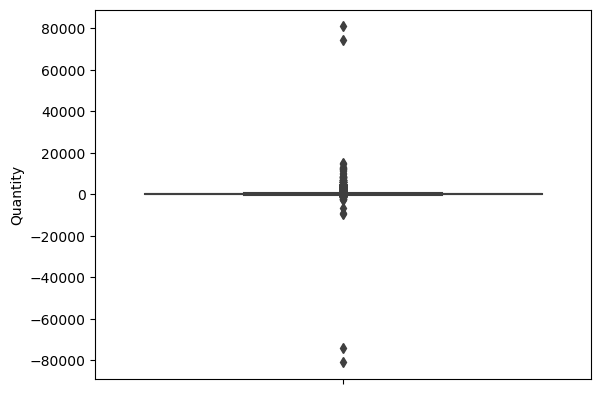

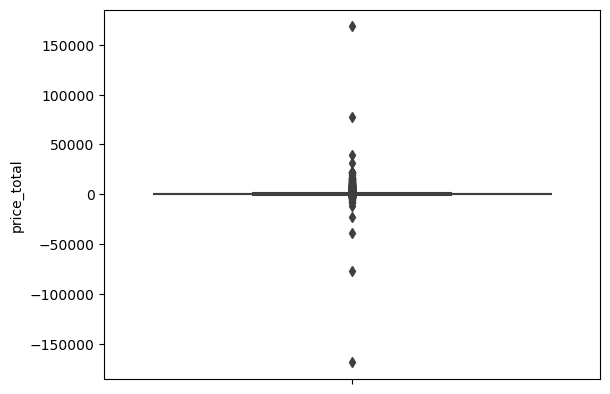

In [302]:
for col in ['Quantity', 'price_total']: 
    sns.boxplot(y=col, data=df)
    plt.show()

### Es claro que tanto en price_total como Quantity tiene valores anomalos negativos y además de outliers

In [303]:
#  Sacando los datos negativos del df (Si tuvieramos la posibilidad de hablar con las personas que recolectaron los datos se podria hacer algo más)
df = df[(df['Quantity'] > 0) & (df['price_total']>0)]

In [304]:
df.describe()

,CustomerID,Quantity,price_total,StockCode
count,18532.000000,18532.000000,18532.000000,18532.000000
mean,15266.378211,278.899363,480.865956,21.471886
std,1734.116296,972.734580,1678.195579,24.920241
min,12346.000000,1.000000,0.380000,1.000000
25%,13776.250000,74.000000,158.037500,6.000000
50%,15178.500000,155.000000,303.040000,15.000000
75%,16779.000000,291.000000,471.840000,28.000000
max,18287.000000,80995.000000,168469.600000,542.000000


C:\Users\kev_g\AppData\Local\Temp\ipykernel_2544\84847413.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


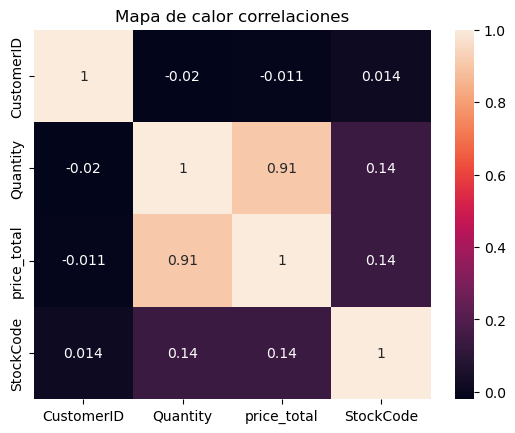

In [305]:
correlation = df.corr()
sns.heatmap(correlation, annot=True)
plt.title('Mapa de calor correlaciones')
plt.show() 

Es claro notar que ninguna de las variables tiene una buena correlación a excepción de price_total y quantity

"price_total": El valor máximo (168469.60) está a más de 5 desviaciones estándar de la media (480.86).
"Quantity": El valor máximo (80995) está a más de 4 desviaciones estándar de la media (278.89)

<Axes: >

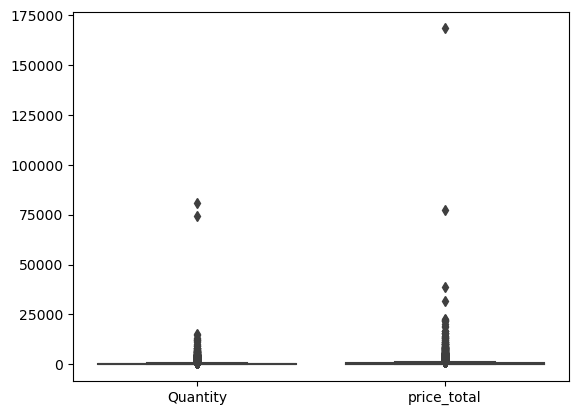

In [306]:
sns.boxplot(df[['Quantity', 'price_total']])

Text(0.5, 1.0, 'Quantity v/s price_total')

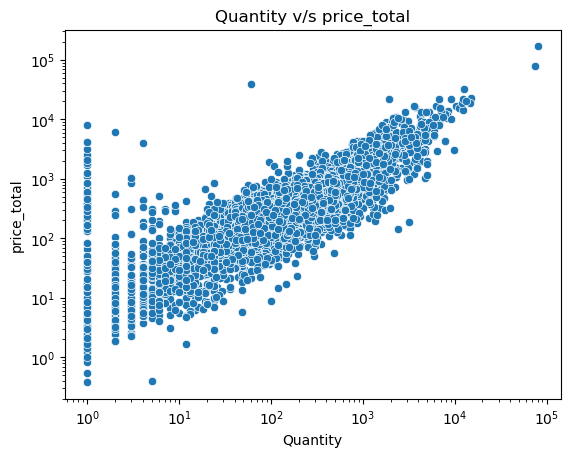

In [307]:
sns.scatterplot(x='Quantity', y='price_total', data=df)
plt.yscale('log')
plt.xscale('log')
plt.title('Quantity v/s price_total')

# Como ser observa en los boxplot existen muchos datos fuera del ultimo percentil. Intenté con un enfoque mas conservador para sacar outliers pero no me gustó ya que los cluster no los hacia bien asi que seguiré con un enfoque más agresivo 

In [308]:
def iqr_outliers(df, column):
    """
    Calcula el IQR y devuelve los índices de los valores atípicos para una columna.

    Parámetros:
    df: DataFrame de Pandas.
    column: Nombre de la columna a analizar.

    Retorno:
    indices_atipicos: Lista con los índices de los valores atípicos.
    """
    
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    # Rango intercuartílico
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    # Índices de valores atípicos
    indices_atipicos = df[column].index[(df[column] < lower_bound) | (df[column] > upper_bound)].tolist()
    df_filtrado = df.drop(indices_atipicos)
    
    return df_filtrado

# Ejemplo de uso
columnas = ['Quantity', 'price_total']

for col in columnas:
    df_filtrado = iqr_outliers(df.copy(), col)
    print(f"Columna {col}:")

#Nuevo dataframe sin outilers
df_filtrado

Columna Quantity:
Columna price_total:


,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1
...,...,...,...,...,...,...
18531,581583,2011-12-09,13777,76,124.60,2
18532,581584,2011-12-09,13777,120,140.64,2
18533,581585,2011-12-09,15804,278,329.05,21
18534,581586,2011-12-09,13113,66,339.20,4


<Axes: >

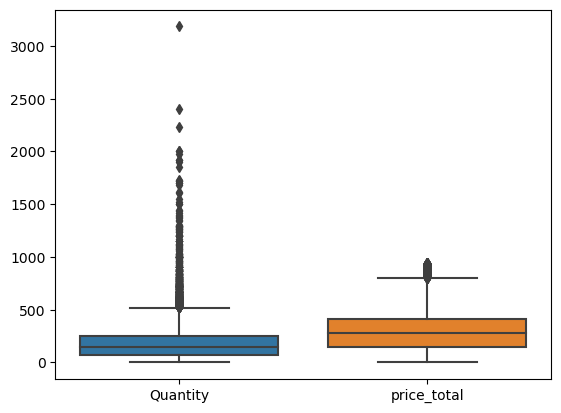

In [309]:
sns.boxplot(df_filtrado[['Quantity', 'price_total']])

Text(0.5, 1.0, 'Histograma Quantity')

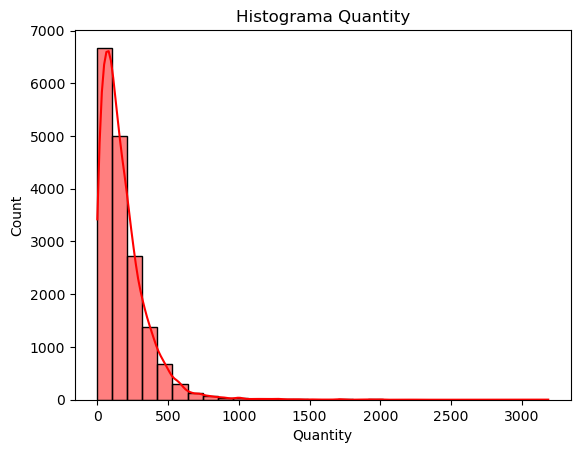

In [310]:
sns.histplot(df_filtrado['Quantity'], bins=30, kde=True, color='red')
plt.title('Histograma Quantity')


Text(0.5, 1.0, 'Histograma price_total')

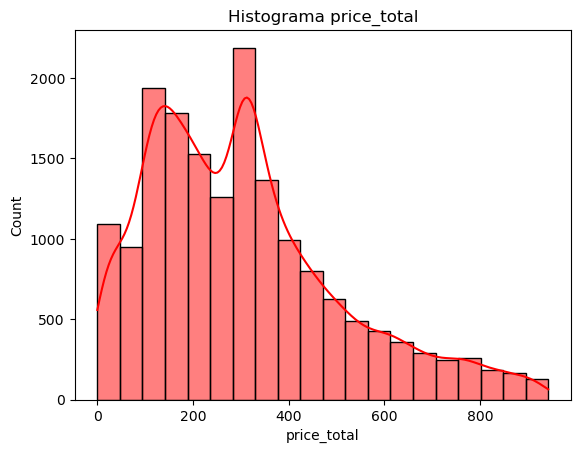

In [311]:
sns.histplot(df_filtrado['price_total'], bins=20, kde=True, color='red')
plt.title('Histograma price_total')


In [312]:
df_filtrado.describe()

,CustomerID,Quantity,price_total,StockCode
count,17066.000000,17066.000000,17066.000000,17066.000000
mean,15288.419079,183.929216,305.709822,19.643150
std,1728.185736,172.036092,203.261717,19.947803
min,12347.000000,1.000000,0.380000,1.000000
25%,13798.000000,70.000000,149.012500,6.000000
50%,15203.000000,142.000000,282.600000,15.000000
75%,16794.000000,250.000000,409.430000,26.000000
max,18287.000000,3186.000000,942.100000,223.000000


 # 2. Generar variables para la segmentación. Notar que la granularidad de la data es por boleta y se necesita segmentar clientes, por lo que es necesario generar variables a nivel de clientes. Se propone generar al menos RFM (Recencia, frecuencia y monto).

In [313]:
df_filtrado

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1
...,...,...,...,...,...,...
18531,581583,2011-12-09,13777,76,124.60,2
18532,581584,2011-12-09,13777,120,140.64,2
18533,581585,2011-12-09,15804,278,329.05,21
18534,581586,2011-12-09,13113,66,339.20,4


In [314]:
# Primero agrupamos por el customerid ya que un mismo customer puede tener mas de 1 pedido. Después aplicamos el maximo para el invoiceDate para conocer la fecha de la ultima compra
fecha_maxima = df_filtrado.groupby('CustomerID')['InvoiceDate'].max().reset_index()
fecha_maxima.columns = ['CustomerID', 'FechaReciente']

# Fusiona el DataFrame original con las fechas máximas
df_filtrado = pd.merge(df_filtrado, fecha_maxima, on='CustomerID', how='left')

# Calcula la recencia para cada transacción
df_filtrado['Recencia'] = (df_filtrado['FechaReciente'] - df_filtrado['InvoiceDate']).dt.days
df_filtrado.drop(columns='FechaReciente', inplace=True)



In [315]:

#Frecuencia (F) para esto agrupamos por customer id y calculamos sobre InvoiceNo aplicando nunique para saber las comprar por clientes
frecuencia_cliente = df_filtrado.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frecuencia_cliente.columns = ['CustomerID', 'Frecuencia']
df_filtrado = pd.merge(df_filtrado, frecuencia_cliente, on='CustomerID', how='left')



In [316]:
#Monto (M) Agrupamos por customerId y sumamos todas las compras
monto_cliente = df_filtrado.groupby('CustomerID')['price_total'].sum().reset_index()
monto_cliente.columns = ['CustomerID', 'Monto']
df_filtrado = pd.merge(df_filtrado, monto_cliente, on='CustomerID', how='left')

# 3. Realizar un análisis exploratorio y las transformaciones necesarias a las nuevas variables

In [317]:
df_filtrado

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode,Recencia,Frecuencia,Monto
0,536365,2010-12-01,17850,40,139.12,7,1,34,5391.21
1,536366,2010-12-01,17850,12,22.20,2,1,34,5391.21
2,536367,2010-12-01,13047,83,278.73,12,342,10,3237.54
3,536368,2010-12-01,13047,15,70.05,4,342,10,3237.54
4,536369,2010-12-01,13047,3,17.85,1,342,10,3237.54
...,...,...,...,...,...,...,...,...,...
17061,581583,2011-12-09,13777,76,124.60,2,0,26,7128.16
17062,581584,2011-12-09,13777,120,140.64,2,0,26,7128.16
17063,581585,2011-12-09,15804,278,329.05,21,0,13,4206.39
17064,581586,2011-12-09,13113,66,339.20,4,0,23,10284.91


In [318]:
df_filtrado.describe()

,CustomerID,Quantity,price_total,StockCode,Recencia,Frecuencia,Monto
count,17066.000000,17066.000000,17066.000000,17066.000000,17066.000000,17066.000000,17066.000000
mean,15288.419079,183.929216,305.709822,19.643150,113.436951,15.792336,4673.426045
std,1728.185736,172.036092,203.261717,19.947803,112.023309,30.199994,9033.294288
min,12347.000000,1.000000,0.380000,1.000000,0.000000,1.000000,2.900000
25%,13798.000000,70.000000,149.012500,6.000000,0.000000,3.000000,810.577500
50%,15203.000000,142.000000,282.600000,15.000000,83.000000,7.000000,1960.720000
75%,16794.000000,250.000000,409.430000,26.000000,199.000000,15.000000,4591.430000
max,18287.000000,3186.000000,942.100000,223.000000,373.000000,205.000000,73642.290000


In [319]:
# Encontrando las columnas RFM
df_filtrado.columns

Index(['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Quantity', 'price_total',
       'StockCode', 'Recencia', 'Frecuencia', 'Monto'],
      dtype='object')

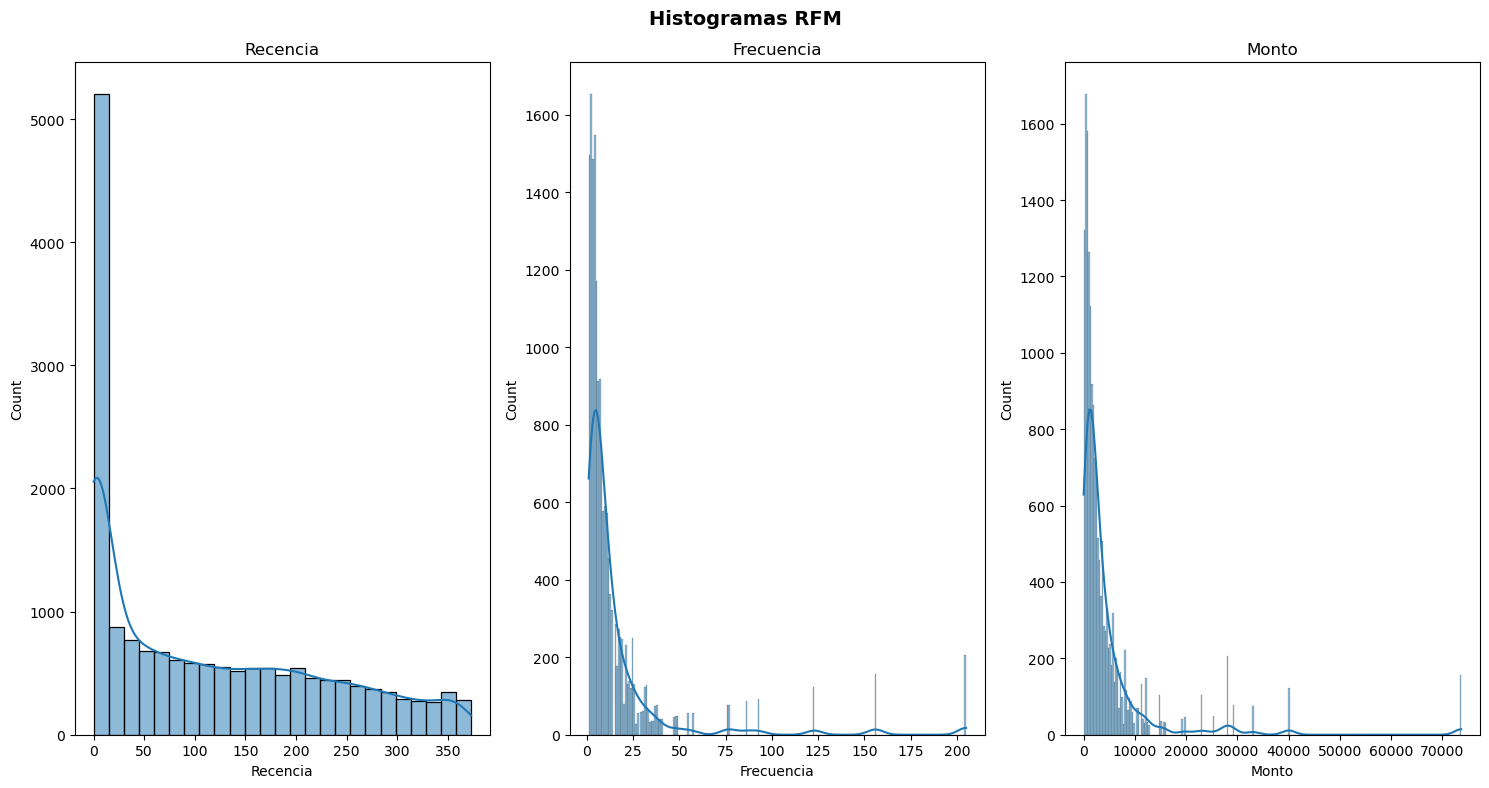

In [320]:
columnas_rfm = df_filtrado.columns[6:]
fig, axes = plt.subplots(1, len(columnas_rfm), figsize=(15, 8))

for i, col in enumerate(columnas_rfm):
    sns.histplot(df_filtrado[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
plt.suptitle('Histogramas RFM', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


In [321]:
df_filtrado.describe()

,CustomerID,Quantity,price_total,StockCode,Recencia,Frecuencia,Monto
count,17066.000000,17066.000000,17066.000000,17066.000000,17066.000000,17066.000000,17066.000000
mean,15288.419079,183.929216,305.709822,19.643150,113.436951,15.792336,4673.426045
std,1728.185736,172.036092,203.261717,19.947803,112.023309,30.199994,9033.294288
min,12347.000000,1.000000,0.380000,1.000000,0.000000,1.000000,2.900000
25%,13798.000000,70.000000,149.012500,6.000000,0.000000,3.000000,810.577500
50%,15203.000000,142.000000,282.600000,15.000000,83.000000,7.000000,1960.720000
75%,16794.000000,250.000000,409.430000,26.000000,199.000000,15.000000,4591.430000
max,18287.000000,3186.000000,942.100000,223.000000,373.000000,205.000000,73642.290000


In [322]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer

# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtrado[['Recencia', 'Frecuencia', 'Monto']])

# 4. Aplicar al menos 2 algoritmos de clustering. Buscar el número indicado de clusters que pueden tener y visualizar los cluster resultantes de los algoritmos

## Según lo que he estado estudiando hay que escalar los datos... pero en nuestra guia no se escalan  por lo que voy a realizar las dos formas y voy a ver cual de las dos se comporta mejor

## Usando los datos escalados

c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\clust

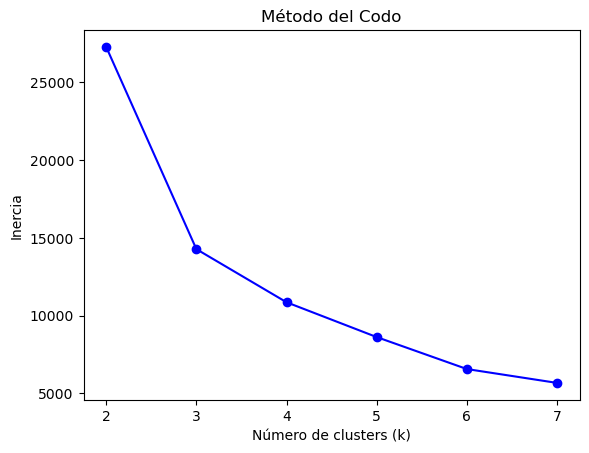

In [323]:
import pandas as pd
from datetime import datetime
from sklearn.cluster import KMeans


# Definir una lista de posibles valores de k para el método del codo
k_values = range(2, 8)

# Inicializar listas para almacenar las métricas
inertia_values = []

# Realizar clustering con diferentes valores de k y calcular las métricas
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    # Calcular la inercia
    inertia_values.append(kmeans.inertia_)

# Graficar el método del codo utilizando la inercia
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.show()

Está claro que el numero de cluster es k=3

c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['Cluster 0', 'Cluster 1', 'Cluster 2']


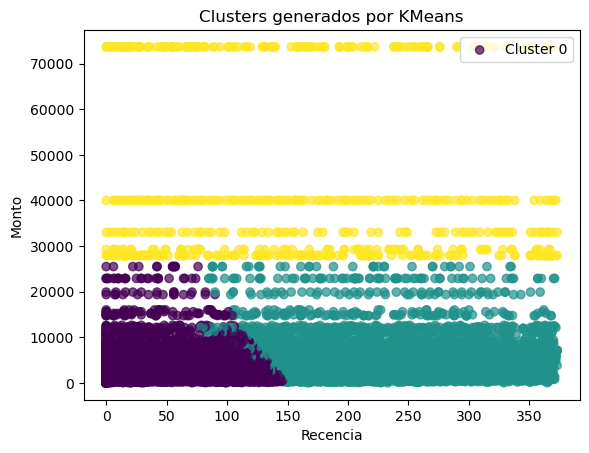

In [324]:
# Aplicar algoritmos de clustering (por ejemplo, KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtrado['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualizar los resultados
plt.scatter(df_filtrado['Recencia'], df_filtrado['Monto'], c=df_filtrado['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Recencia')
plt.ylabel('Monto')
plt.title('Clusters generados por KMeans')

# Obtener etiquetas únicas de los clusters
unique_labels = df_filtrado['Cluster'].unique()

# Generar etiquetas para la leyenda
legend_labels = [f'Cluster {label}' for label in unique_labels]
print(legend_labels)
# Agregar leyenda
plt.legend(legend_labels, loc='upper right')
plt.show()


# Sin escalar

c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\clust

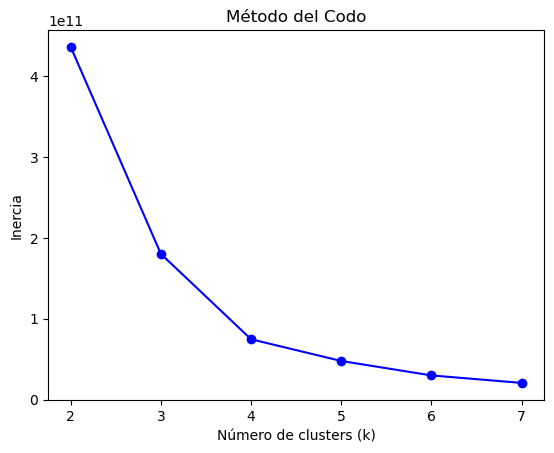

In [325]:

X =df_filtrado[['Recencia', 'Frecuencia', 'Monto']]
import pandas as pd
from datetime import datetime
from sklearn.cluster import KMeans


# Definir una lista de posibles valores de k para el método del codo
k_values = range(2, 8)

# Inicializar listas para almacenar las métricas
inertia_values = []

# Realizar clustering con diferentes valores de k y calcular las métricas
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    # Calcular la inercia
    inertia_values.append(kmeans.inertia_)

# Graficar el método del codo utilizando la inercia
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.show()

c:\Users\kev_g\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['Cluster 0', 'Cluster 1', 'Cluster 2']


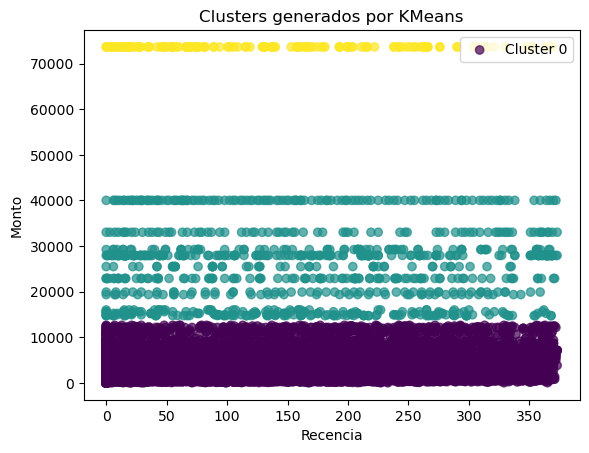

In [326]:
# Aplicar algoritmos de clustering (por ejemplo, KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtrado['Cluster'] = kmeans.fit_predict(X)

# Visualizar los resultados
plt.scatter(df_filtrado['Recencia'], df_filtrado['Monto'], c=df_filtrado['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Recencia')
plt.ylabel('Monto')
plt.title('Clusters generados por KMeans')

# Obtener etiquetas únicas de los clusters
unique_labels = df_filtrado['Cluster'].unique()

# Generar etiquetas para la leyenda
legend_labels = [f'Cluster {label}' for label in unique_labels]
print(legend_labels)
# Agregar leyenda
plt.legend(legend_labels, loc='upper right')
plt.show()


## 2NDO ALGORITMO DE CLUSTERS

## Sin escalar como en la guia de estudio y por un tema de recursos no generare el escalado

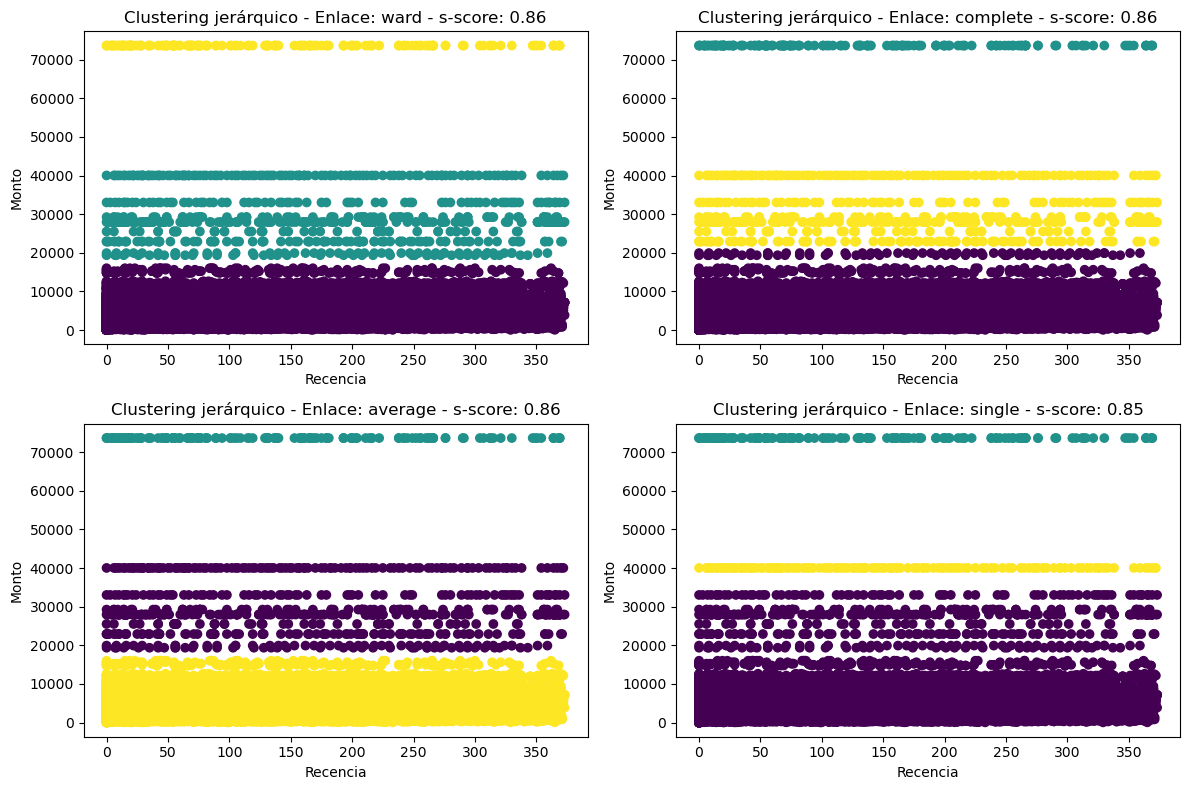

In [327]:
#jerarquicos

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

# Seleccionar las columnas relevantes para el clustering jerárquico
X = df_filtrado[['Recencia', 'Monto', 'Frecuencia']]

# Crear lista de métodos de enlace
linkage_methods = ['ward', 'complete', 'average', 'single']

# Configurar la visualización
plt.figure(figsize=(12, 8))

# Iterar sobre los métodos de enlace y realizar clustering jerárquico
for i, method in enumerate(linkage_methods):
    # Realizar clustering jerárquico con el método de enlace actual
    clustering = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = clustering.fit_predict(X)
    sc = silhouette_score(X, labels)

    # Graficar los puntos en un diagrama de dispersión para las dos primeras columnas
    plt.subplot(2, 2, i+1)
    plt.scatter(X['Recencia'], X['Monto'], c=labels, cmap='viridis')
    plt.xlabel('Recencia')
    plt.ylabel('Monto')
    plt.title(f'Clustering jerárquico - Enlace: {method} - s-score: {sc:.2f}')

plt.tight_layout()
plt.show()

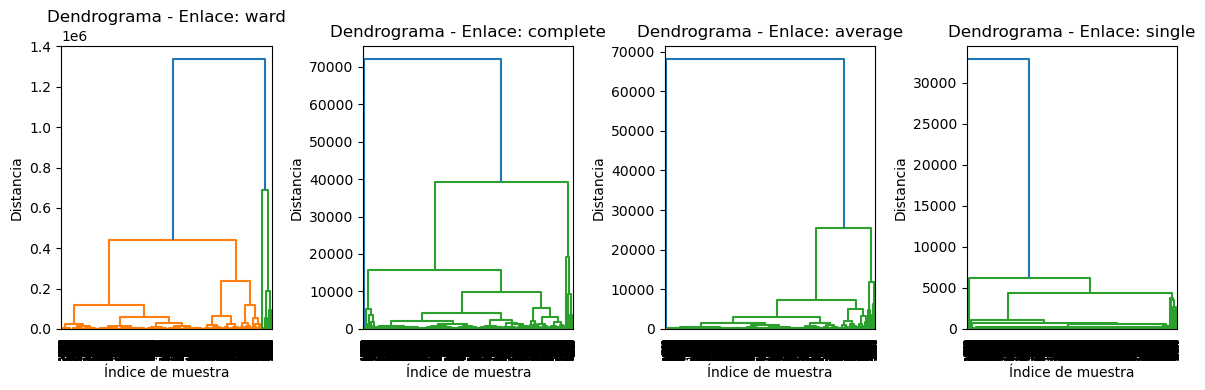

In [473]:

# Graficar los dendrogramas
plt.figure(figsize=(12, 4))
# Iterar sobre los métodos de enlace y graficar los dendrogramas
for i, method in enumerate(linkage_methods):
    # Realizar clustering jerárquico con el método de enlace actual
    Z = linkage(X, method)

    # Convertir la matriz de enlace a tipo float
    Z = Z.astype(float)

    # Graficar el dendrograma
    plt.subplot(1, 4, i+1)
    dendrogram(Z)
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.title(f'Dendrograma - Enlace: {method}')

plt.tight_layout()
plt.show()

# 5. Evaluar la calidad de los clustering de forma numérica y realizar una explicación de cada segmento asignándoles un nombre descriptivo

## Sin escalar: Análisis numerico cluster

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances

labels = kmeans.labels_
silhouette_scores = silhouette_score(X, labels)
# Calcular el índice de Dunn
dunn_index = davies_bouldin_score(X, labels)
print(f'Silhoutte Score : {silhouette_scores}')
print(f'Davies Bouldin Score : {dunn_index}')

Silhoutte Score : 0.8542441376861063
Davies Bouldin Score : 0.26587319742489895


El silhoutte nos inde  que los puntos de datos dentro de los grupos están bien agrupados y bien separados de los puntos de otros grupos. Además el otro indice davies bouldien nos indica que los grupos se encuentran bien separado.

## Escalado: Análisis numerico cluster

In [448]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances

labels = kmeans.labels_
silhouette_scores = silhouette_score(df_scaled, labels)
# Calcular el índice de Dunn
dunn_index = davies_bouldin_score(df_scaled, labels)
print(f'Silhoutte Score : {silhouette_scores}')
print(f'Davies Bouldin Score : {dunn_index}')

Silhoutte Score : 0.5515526770737288
Davies Bouldin Score : 0.6672734917986872


Al igual que el anterior nos indica buena separación pero no tanto como el anterior por lo que deberian desempeñarse mejor los clusters anteriores

Es claro notar que el modelo que mejor se adpta es el que no se encuentra escalado como vimos en la guia de estudio en desmedro del que está escalado.

In [329]:
# Asignar nombres descriptivos a los clusters
cluster_names = {
    0: 'Bajo poder adquisitivo',
    1: 'Medio poder adquisitivo',
    2: 'Alto poder adquisitivo'
}
df_filtrado['Cluster_Name'] = df_filtrado['Cluster'].map(cluster_names)

# Imprimir resultados
df_filtrado[['CustomerID', 'Recencia', 'Frecuencia', 'Monto', 'Cluster', 'Cluster_Name']]

,CustomerID,Recencia,Frecuencia,Monto,Cluster,Cluster_Name
0,17850,1,34,5391.21,0,Bajo poder adquisitivo
1,17850,1,34,5391.21,0,Bajo poder adquisitivo
2,13047,342,10,3237.54,0,Bajo poder adquisitivo
3,13047,342,10,3237.54,0,Bajo poder adquisitivo
4,13047,342,10,3237.54,0,Bajo poder adquisitivo
...,...,...,...,...,...,...
17061,13777,0,26,7128.16,0,Bajo poder adquisitivo
17062,13777,0,26,7128.16,0,Bajo poder adquisitivo
17063,15804,0,13,4206.39,0,Bajo poder adquisitivo
17064,13113,0,23,10284.91,0,Bajo poder adquisitivo


In [330]:
df_filtrado.sort_values(by='Monto', ascending=False)

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode,Recencia,Frecuencia,Monto,Cluster,Cluster_Name
12796,570839,2011-10-12,14911,406,749.67,39,54,156,73642.29,2,Alto poder adquisitivo
9184,561257,2011-07-26,14911,252,396.77,7,132,156,73642.29,2,Alto poder adquisitivo
2199,542777,2011-02-01,14911,463,797.77,45,307,156,73642.29,2,Alto poder adquisitivo
214,536803,2010-12-02,14911,6,22.50,1,368,156,73642.29,2,Alto poder adquisitivo
7619,557136,2011-06-17,14911,356,626.13,33,171,156,73642.29,2,Alto poder adquisitivo
...,...,...,...,...,...,...,...,...,...,...,...
13505,572832,2011-10-26,16454,1,1.00,1,0,2,6.90,0,Bajo poder adquisitivo
12487,570003,2011-10-07,14792,2,6.20,2,0,1,6.20,0,Bajo poder adquisitivo
11557,567642,2011-09-21,12409,1,4.95,1,0,1,4.95,0,Bajo poder adquisitivo
2609,543986,2011-02-15,16738,3,3.75,1,0,1,3.75,0,Bajo poder adquisitivo


In [331]:
df_filtrado.groupby('Cluster_Name')[['Quantity', 'price_total', 'Frecuencia']].sum()

,Quantity,price_total,Frecuencia
Cluster_Name,,,
Alto poder adquisitivo,40606,73642.290,24336
Bajo poder adquisitivo,2896098,4811485.603,157603
Medio poder adquisitivo,202232,332115.930,87573


## Debido a que para los 3 clusters la recencia existe de 0 hasta su valor más alto está claro que tenemos que segmentar por el monto que gastan es así que propongo
## 1. Bajo poder adquisitivo donde existen compradores habituales y pasivos. Correspondera a la mayor cantidad de ventas tanto en cantidad como en el total
## 2. Medio poder adquisitivo al igual que el anterior se compone de todo tipo de compradores pero estos tienden a gastar más dinero. Estos corresponden a la segunda mayor fuerza en cuanto a cantidad y al total.
## 3. Alto poder adquisitivo son mucho más exclusivos y se caracterizan por gastar mucho mas dinero. Aún asi estos corresponden a la menor cantidad de price_total y cantidad